___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [2]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [3]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [4]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


### Plot the source data

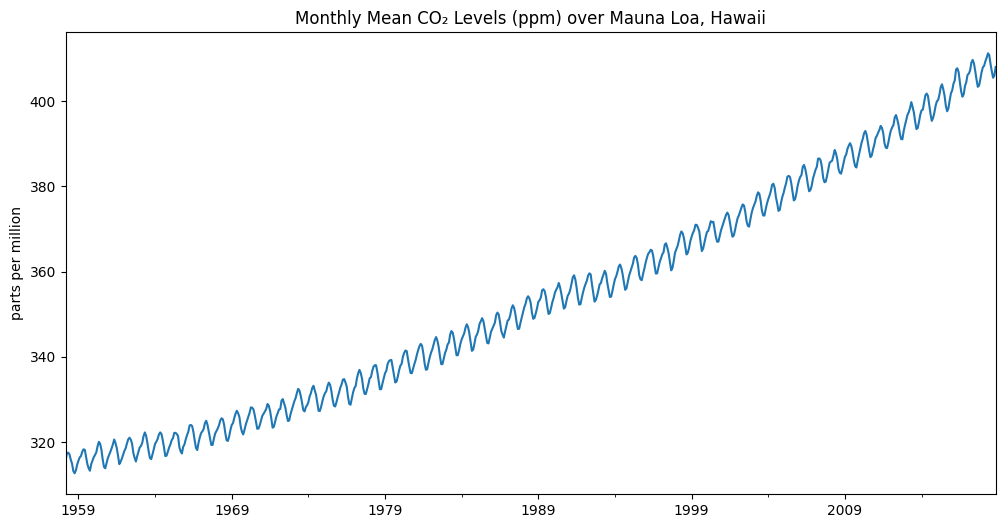

In [5]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Run an ETS Decomposition

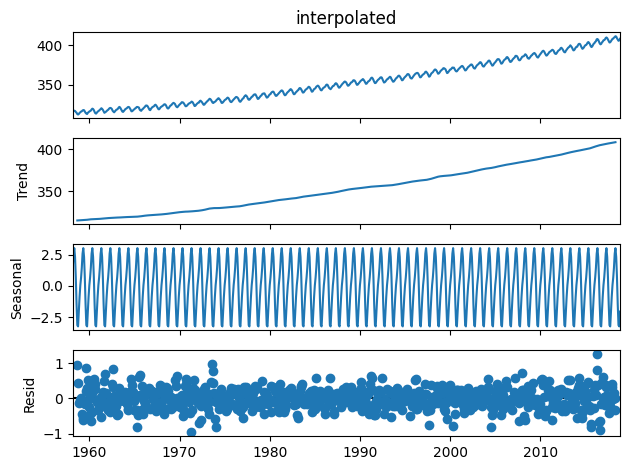

In [6]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [7]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.302
Date:                            Fri, 04 Oct 2024   AIC                            424.604
Time:                                    10:49:28   BIC                            452.146
Sample:                                03-01-1958   HQIC                           435.231
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3501      0.046      7.685      0.000       0.261       0.439
ar.L2          0.0866      0.012      7.384      0.000       0.064       0.110
ma.L1         -0.7053      0.040    -17.691      0.000      -0.783      -0.627
ar.S.L12       0.9996      0.000   2429.159      0.000       0.999       1.000
ma.S.L12      -0.8634      0.022    -39.611      0.000      -0.906      -0.821
sigma2         0.0958      0.005     20.805      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.33
Prob(Q):                              0.80   Prob(JB):                         0.12
Heteroskedasticity (H):               1.12   Skew:                            -0.00
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [8]:
len(df)

729

In [9]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [10]:
model = SARIMAX(train['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01395D-01    |proj g|=  6.33009D-01

At iterate    5    f=  5.62395D-01    |proj g|=  2.16516D-01

At iterate   10    f=  2.98390D-01    |proj g|=  4.41590D-02

At iterate   15    f=  2.91598D-01    |proj g|=  2.68106D-03

At iterate   20    f=  2.90260D-01    |proj g|=  4.64336D-02

At iterate   25    f=  2.89604D-01    |proj g|=  6.80994D-03

At iterate   30    f=  2.85770D-01    |proj g|=  3.87968D-02

At iterate   35    f=  2.81732D-01    |proj g|=  8.17495D-03

At iterate   40    f=  2.81599D-01    |proj g|=  4.20865D-03

At iterate   45    f=  2.81576D-01    |proj g|=  3.15334D-04

At iterate   50    f=  2.81575D-01    |proj g|=  2.47603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.889
Date:                            Fri, 04 Oct 2024   AIC                            415.779
Time:                                    10:50:04   BIC                            443.221
Sample:                                03-01-1958   HQIC                           426.376
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3527      0.043      8.132      0.000       0.268       0.438
ar.L2          0.0854      0.019      4.553      0.000       0.049       0.122
ma.L1         -0.7066      0.045    -15.706      0.000      -0.795      -0.618
ar.S.L12       0.9996      0.000   2565.717      0.000       0.999       1.000
ma.S.L12      -0.8648      0.023    -37.652      0.000      -0.910      -0.820
sigma2         0.0953      0.005     20.512      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.63
Prob(Q):                              0.80   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,1)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [13]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.5994571, expected=406.81
predicted=407.8161115, expected=407.96
predicted=408.570877 , expected=408.32
predicted=409.4806733, expected=409.41
predicted=411.041954 , expected=410.24
predicted=411.6465959, expected=411.24
predicted=410.8662147, expected=410.79
predicted=409.1756242, expected=408.71
predicted=407.0756567, expected=406.99
predicted=405.625961 , expected=405.51
predicted=405.897525 , expected=406.0
predicted=407.4320082, expected=408.02


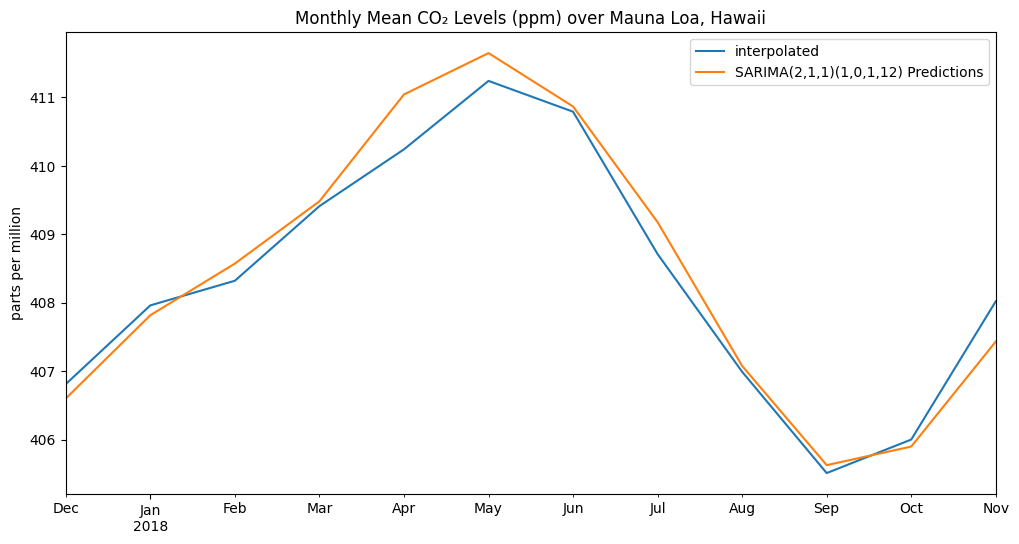

In [14]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [15]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(2,1,1)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(2,1,1)(1,0,1,12) MSE Error: 0.1284208975


In [16]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3583586157


These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [17]:
model = SARIMAX(df['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(2,1,1)(1,0,1,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97985D-01    |proj g|=  6.23769D-01


 This problem is unconstrained.



At iterate    5    f=  5.54166D-01    |proj g|=  2.10623D-01

At iterate   10    f=  3.15786D-01    |proj g|=  1.54532D-01

At iterate   15    f=  3.06421D-01    |proj g|=  3.88362D-02

At iterate   20    f=  3.05972D-01    |proj g|=  4.74286D-02

At iterate   25    f=  3.01901D-01    |proj g|=  1.11332D-01

At iterate   30    f=  3.00417D-01    |proj g|=  1.41425D-02

At iterate   35    f=  2.96775D-01    |proj g|=  2.54689D-02

At iterate   40    f=  2.83424D-01    |proj g|=  7.94152D-03

At iterate   45    f=  2.83010D-01    |proj g|=  1.05452D-02

At iterate   50    f=  2.82993D-01    |proj g|=  2.74935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

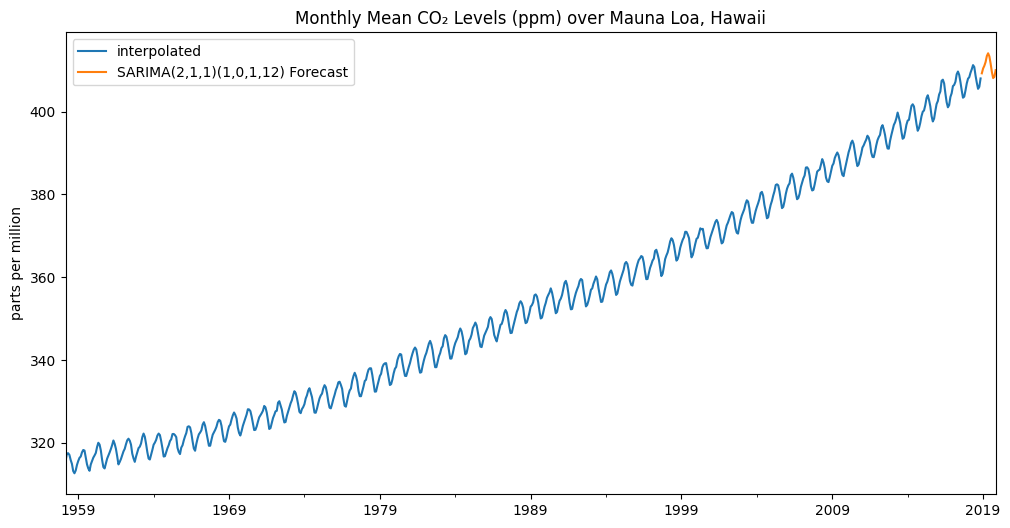

In [18]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Great job!